In [1]:
# imports of used modules

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle


In [2]:
#################################################################

########     H E L P E R - F U N C T I O N S   ##################

#################################################################

In [36]:
# Function plots 2 images side by side

def plot2images( title1, img1, title2, img2, savename=''):
    plt.figure(figsize=(15,5))

    # subplot(nrows, ncols, plot_number)    
    plt.subplot(1, 2, 1)
    plt.title( title1, fontsize=20)
    plt.imshow(img1)

    plt.subplot(1, 2, 2)
    plt.title( title2,  fontsize=20)
    plt.imshow(img2)

    if savename != '':        
        path = 'output_images/'+savename
        plt.savefig( path )
        print('Saved image to: ', path)
    
    plt.show()

In [4]:
#################################################################

########     I M A G E - P R E P R O C E S S I N G    ###########

#################################################################

In [5]:
# function to undistort an image

def undistort_img(img):
    # Read in the saved matrix and distortion coefficients
    # ! make sure that camera_calibration.ipynb has run once before to calibrate the camera
    # ! otherwise the calibration file doesn't exist and cannot be loaded
    dist_pickle = pickle.load(open('./camera_cal/calibrationPickle.p', 'rb'))
    mtx = dist_pickle['mtx']
    dist = dist_pickle['dist']    
    # return undistorted image
    return cv2.undistort(img, mtx, dist, None, mtx)


Saved image to:  output_images/writeup_combi_rs_channels.jpg


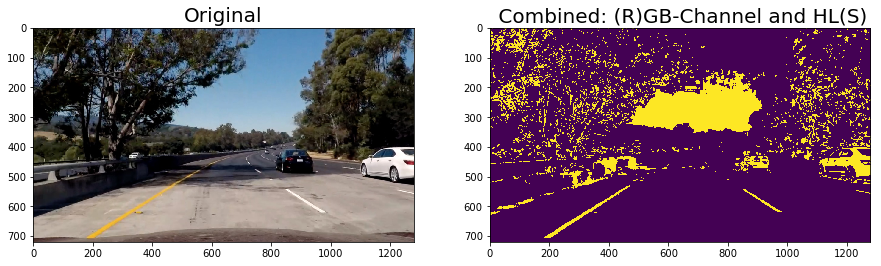

In [37]:
def color_threshold_old(img, r_thresh=(0, 255), s_thresh=(0, 255)):
    """
    Convertes a RGB color image input into a combined image wiht just R Channel of RGB and
    S-Channel from HLS color spaces
    
    The threshold parameters r_thresh and s_thresh (0 to 255) 
    determin the minimum and maximum values a pixels must have in a channel to be included in the 
    binary output        
    """
    
    # Apply a threshold to the R channel
    r_channel = img[:,:,2].copy()
    r_binary = np.zeros_like(img[:,:,0])
    # Create a mask of Ones (1) where pixel value is within the given thresholds
    r_binary[(r_channel > r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
    
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Apply a threshold to the S channel
    s_channel = hls[:,:,2].copy()
    s_binary = np.zeros_like(s_channel)
    # Create a mask of Ones (1) where pixel value is within the given thresholds
    s_binary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Combine two channels
    combined = np.zeros_like(img[:,:,0].copy())
    combined[(s_binary == 1) | (r_binary == 1)] = 1
    
    # Return binary output image
    return combined
    
        
# Debug output
img = mpimg.imread('./test_images/test5.jpg')
undist = undistort_img(img)
# Threshold color
color_binary = color_threshold_old(undist, r_thresh=(200, 255), s_thresh=(150, 255))
plot2images('Original',undist, ' Combined: (R)GB-Channel and HL(S)',color_binary,'writeup_combi_rs_channels.jpg')


Saved image to:  output_images/writeup_combi_lb_channels.jpg


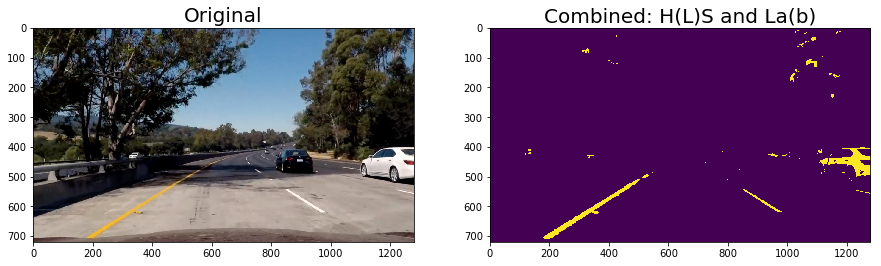

In [74]:
def color_threshold(img, l_thresh=(220,255), b_thresh=(190, 255), s_thresh=(220, 255)):
    
    # Convertes a RGB color image input into a combined image            
    # thresholds the L-channel of HLS and B-Channel of Lab    

    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
    hls_l = hls_l*(255/np.max(hls_l))
    # 2) Apply a threshold to the L channel
    binary_output_l = np.zeros_like(hls_l)
    binary_output_l[(hls_l > l_thresh[0]) & (hls_l <= l_thresh[1])] = 1
    
    """
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_s = hls[:,:,2]
    hls_s = hls_s*(255/np.max(hls_l))
    # 2) Apply a threshold to the S channel
    binary_output_s = np.zeros_like(hls_s)
    binary_output_s[(hls_s > s_thresh[0]) & (hls_s <= s_thresh[1])] = 1
    """
    
    # The B channel captures yellows
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # Tuning: Normalize only if there is yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))

    binary_output_b = np.zeros_like(lab_b)
    binary_output_b[((lab_b > b_thresh[0]) & (lab_b <= b_thresh[1]))] = 1
    
    # Combine HLS and Lab B channel thresholds
    combined = np.zeros_like(binary_output_l)
    combined[(binary_output_l == 1) | (binary_output_b == 1)] = 1
    #combined[(binary_output_s == 1) | (binary_output_b == 1)] = 1
    
    # Return a binary output image
    return combined
            
# Debug output
img = mpimg.imread('./test_images/test5.jpg')
undist = undistort_img(img)
# Threshold color
color_binary = color_threshold(undist)
plot2images('Original',undist, 'Combined: H(L)S and La(b)',color_binary, 'writeup_combi_lb_channels.jpg')
#plot2images('Original',undist, 'Combined: HL(S) and La(b)',color_binary, 'writeup_combi_sb_channels.jpg')



Saved image to:  output_images/writeup_sobel_mag.jpg


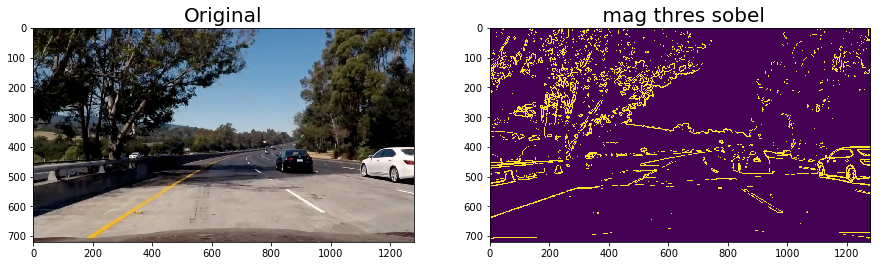

In [40]:

# Reference: Udacity lesson 22 

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values

def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image    
    return binary_output



In [44]:
# Reference: Code from Quiz Lesson 23 of lecture

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


Saved image to:  output_images/writeup_sobel_mag.jpg


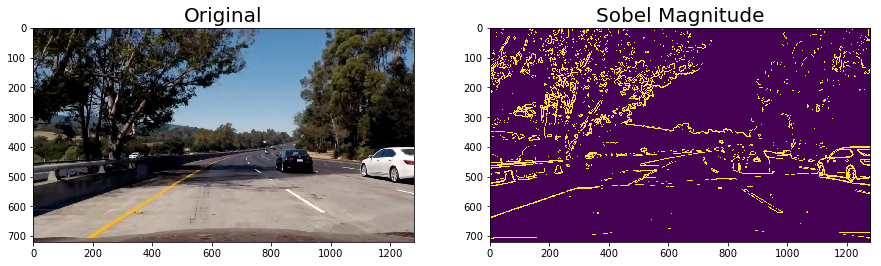

Saved image to:  output_images/writeup_sobel_dir.jpg


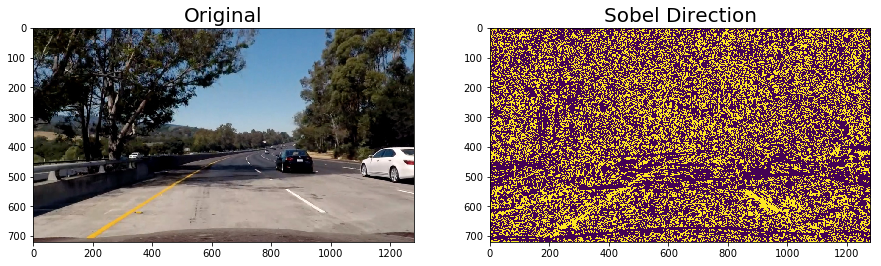

Saved image to:  output_images/writeup_sobel_mag_and_dir.jpg


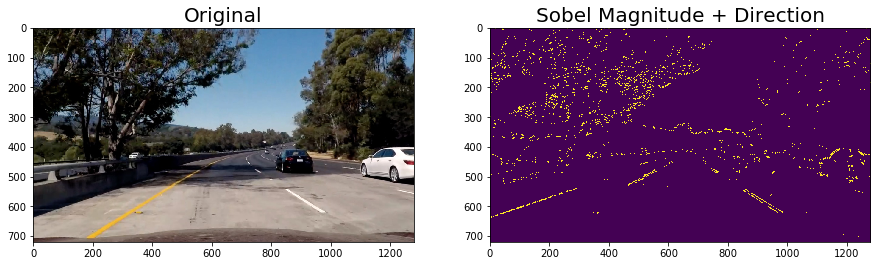

Saved image to:  output_images/writeup_sobel_color_r_s.jpg


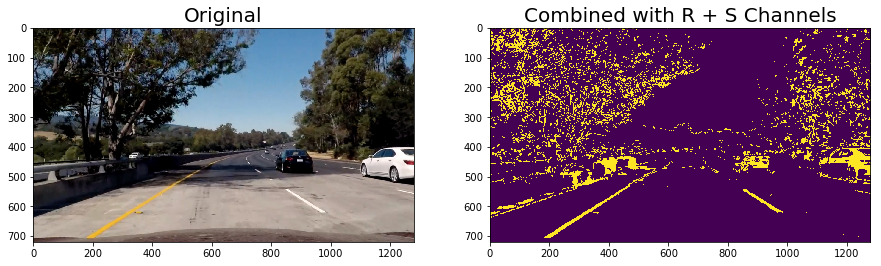

Saved image to:  output_images/writeup_sobel_color_l_b.jpg


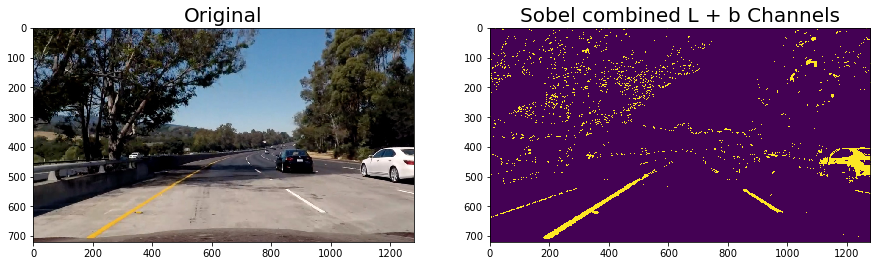

Saved image to:  output_images/writeup_color_l_b.jpg


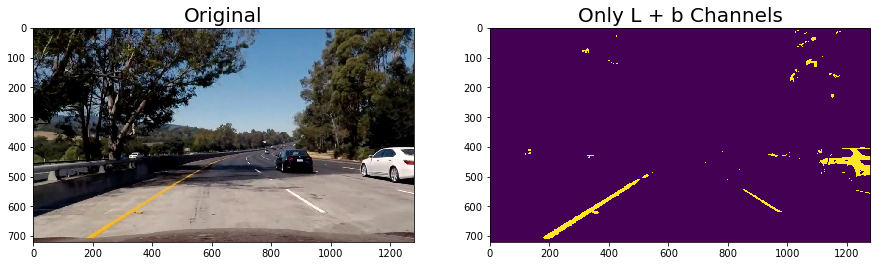

In [48]:

# Debug output
img = mpimg.imread('./test_images/test5.jpg')
undist = undistort_img(img)
mag_binary = mag_threshold(undist, sobel_kernel=9, mag_thresh=(50, 255))
plot2images('Original',undist, 'Sobel Magnitude',mag_binary, 'writeup_sobel_mag.jpg')

# Debug output
img = mpimg.imread('./test_images/test5.jpg')
img = undistort_img(img)
dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
plot2images('Original',img, 'Sobel Direction',dir_binary, 'writeup_sobel_dir.jpg')

mag_binary = mag_threshold(undist, sobel_kernel=9, mag_thresh=(50, 255))

grad_binary = np.zeros_like(img[:,:,0])
grad_binary[((mag_binary == 1) & (dir_binary == 1))] = 1
sobel_binary = grad_binary.copy()
plot2images('Original',undist, 'Sobel Magnitude + Direction',grad_binary, 'writeup_sobel_mag_and_dir.jpg')

# Threshold color
color_binary = color_threshold_old(img, r_thresh=(220, 255), s_thresh=(150, 255))

# Combine gradient and old color channels
combo_binary = np.zeros_like(img[:,:,0])
combo_binary[(grad_binary == 1) | (color_binary == 1)] = 255

plot2images('Original',undist, 'Combined with R + S Channels',combo_binary, 'writeup_sobel_color_r_s.jpg')

# new color channels
color_binary = color_threshold(img)
# Combine gradient and color thresholds
combo_binary = np.zeros_like(img[:,:,0])
combo_binary[(sobel_binary == 1) | (color_binary == 1)] = 255
plot2images('Original',undist, 'Sobel combined L + b Channels',combo_binary, 'writeup_sobel_color_l_b.jpg')

# new color channels
plot2images('Original',undist, 'Only L + b Channels',color_binary, 'writeup_color_l_b.jpg')



In [10]:

# Define parameter set  for the perspective warp. 
# I used straight_lines2.jpg to get the pixel values in src
# I transformed to a much wider output to focus on the lane 
# and drop cars and trees next to the lane

def get_warp_parameters():
    
    # Helper function to calculate transformation matrix    
    src = np.float32([(575,465), (710,465),  (260,680),  (1050,680)])    
    dst = np.float32([(450,0), (830,0), (450,720), (830,720)])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

# Call function and store Matrix and inverse Matrix
M, Minv = get_warp_parameters()



Saved image to:  output_images/writeup_warped_color.jpg


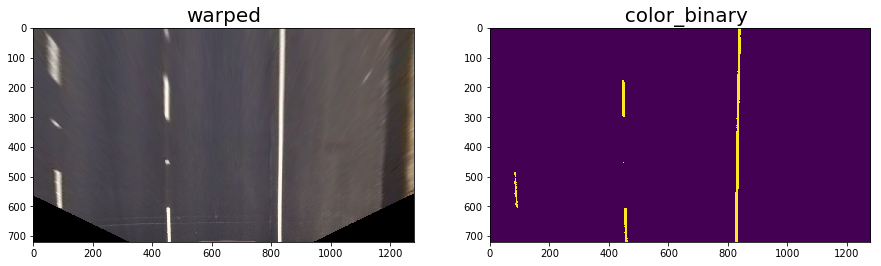

Saved image to:  output_images/writeup_color_warped.jpg


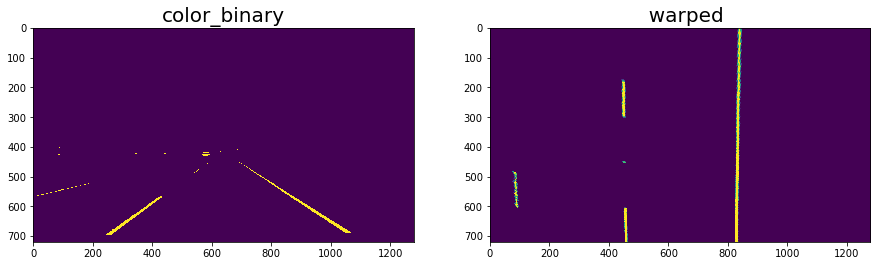

In [50]:

# function that applies a perspective warp to an image
    
def warp(img):   
    M, Minv = get_warp_parameters()
    return cv2.warpPerspective(img, M, (1280,720), flags=cv2.INTER_LINEAR)

## Debut output
img = mpimg.imread('./test_images/straight_lines2.jpg')
undist = undistort_img(img)

# Threshold color

# 1st try: first warp, then color binary  (better)
# ------------------------
warped = warp(undist)
color_binary = color_threshold(warped) #, r_thresh=(225, 255), s_thresh=(150, 255))
plot2images('warped',warped, '  color_binary',color_binary, 'writeup_warped_color.jpg')

# 2nd try : start with color binary, then warp 
# ------------------------
color_binary = color_threshold(undist) #, r_thresh=(225, 255), s_thresh=(150, 255))
#warped = warp(color_binary)
warped = warp(color_binary)

plot2images('color_binary',color_binary, '  warped',warped, 'writeup_color_warped.jpg')



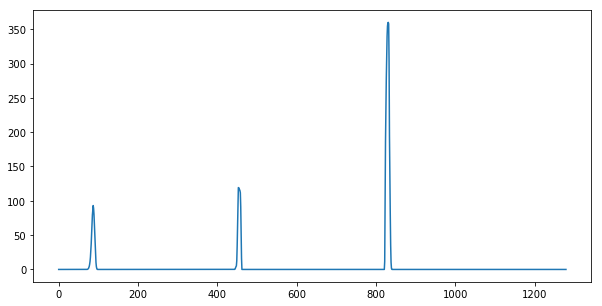

Left Maximum: 452 Right Maximum 831
Lane width in px: 379


In [55]:
def plotHistogram(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)        
    
    plt.figure(figsize=(10,5))
    plt.plot(histogram)
    plt.savefig( 'output_images/histogram.jpg' )    
    plt.show()
    
    left = histogram[1:600].copy()
    right = np.append( np.zeros(600), histogram[600:1200] )
    left_max = np.argmax(left)
    right_max = np.argmax(right)
    print('Left Maximum: %d Right Maximum %d' % (left_max , right_max) ) 
    lane_width = right_max-left_max    
    print ('Lane width in px:' , lane_width)
    
plotHistogram(warped)


In [13]:
# Lesson 35:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension , 720 px = height of the testimages
xm_per_pix = 3.7/382 # meters per pixel in x dimension  619 px = distance in warped testimage inside 1 lane


In [14]:
###############################################
########     main:  LANE FINDING    ###########
###############################################

In [15]:
## Calculate Offset
## image size is 1280 x 720

def calculate_offset(left_fit, right_fit):
    y = 720
    xl = left_fit[0]* y**2 + left_fit[1]*y + left_fit[2]  
    xr = right_fit[0]* y**2 + right_fit[1]*y + right_fit[2]

    car_position = img.shape[1]/2
    lane_center_position = (xr + xl)/2
    offset_lane = (car_position - lane_center_position)*xm_per_pix
    return offset_lane

#Demo
#offset_lane = calculate_offset(left.fit_smooth, right.fit_smooth)
#print('Offset from middle of the lane: ', offset_lane*100, 'cm')


./test_images\test1.jpg


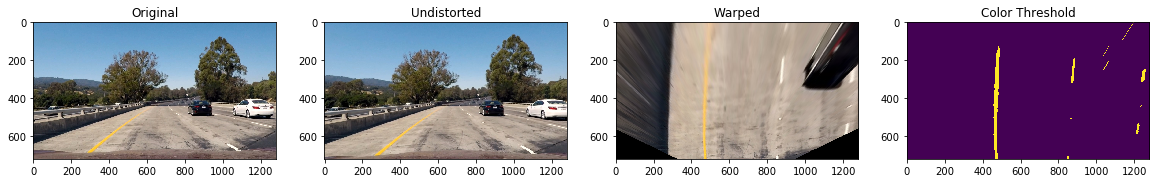

./test_images\test2.jpg


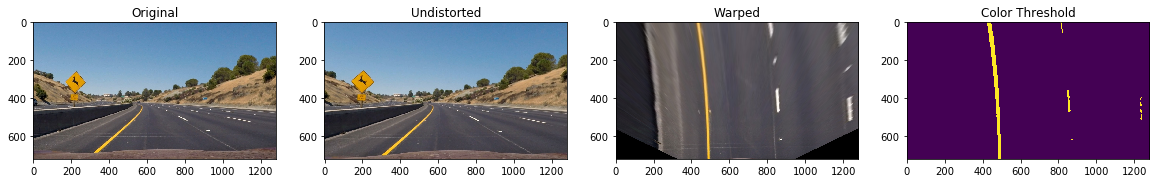

./test_images\test3.jpg


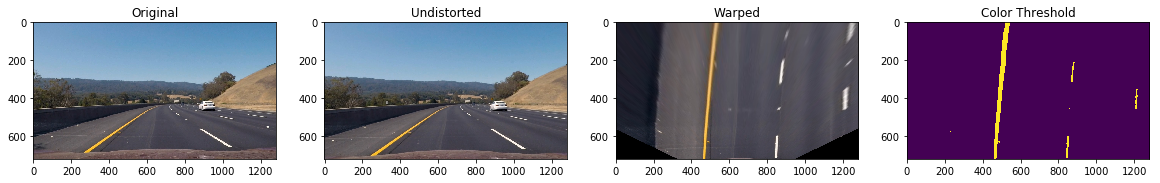

./test_images\test4.jpg


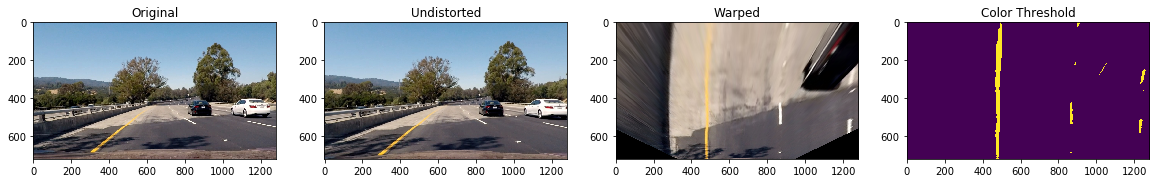

./test_images\test5.jpg


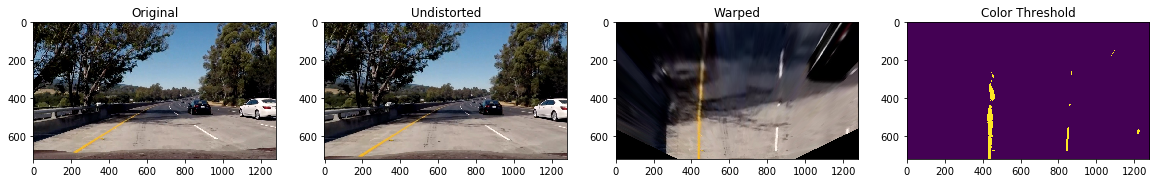

./test_images\test6.jpg


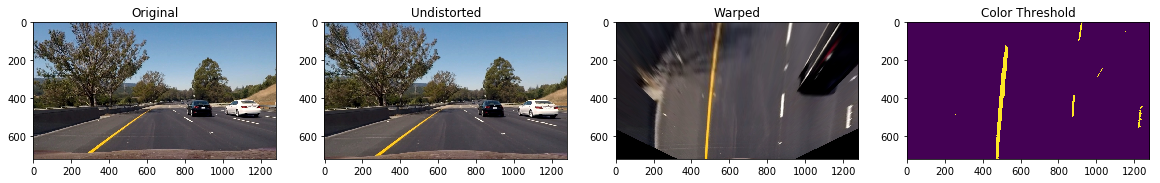

In [16]:
##########################################
# I M A G E - P R E P R O C E S S I N G
##########################################

def preprocess_image(img, debug=False):
               
    # 1. undistort image
    undist = undistort_img(img)       
    if debug:
        plt.figure(figsize=(20,15))
                
        plt.subplot(141)
        plt.title('Original')
        plt.imshow(img)
                
        plt.subplot(142)
        plt.title('Undistorted')
        plt.imshow(undist)

    """
    # Tried out but discarded because there was no performance gain
    
    # 2. Create binary image with thresholds for colors and gradients
    
    # Threshold gradient
    grad_binary = np.zeros_like(img[:,:,0])
    
    # filter on magnitude of the gradient
    mag_binary = mag_threshold(undist, sobel_kernel=9, mag_thresh=(50, 255))
    
    # filter on direction of the gradient    
    dir_binary = dir_threshold(undist, sobel_kernel=15, thresh=(0.7, 1.3))
    
    # combine 2 filters
    grad_binary[((mag_binary == 1) & (dir_binary == 1))] = 1
    """
            
    # 3. perspective transform image
    warped = warp(undist)        
    if debug:
        plt.subplot(143)
        plt.title('Warped')
        plt.imshow(warped)
        cv2.imwrite('warped_example.jpg', warped)
           
            
    # Threshold color channels    
    color_binary = color_threshold(warped)
    if debug:
        plt.subplot(144)
        plt.title('Color Threshold')
        plt.imshow(color_binary)

    """
    # Tried out but discarded because there was no performance gain
    # Combine gradient and color thresholds
    combined_binary = np.zeros_like(img[:,:,0])
    combined_binary[(grad_binary == 1) | (color_binary == 1)] = 255
        
    if debug:
        plt.subplot(143)
        plt.title('Gradient and Colort threshold')
        plt.imshow(combined_binary)
    
    # 3. perspective transform image
    #warped = warp(combined_binary)
        
    
    if debug:
        plt.subplot(155)
        plt.title('Result')
        plt.imshow(warped)
        plt.show()
    return warped
    """    
    result = color_binary
    return result

#  Process test images and show results before and after
images = glob.glob('./test_images/test*')

for n, filename in enumerate(images):
    print (filename )
    img = mpimg.imread(filename)    
    preprocess_image(img, debug=True)
    plt.show()
    

In [17]:
# Source: Lesson 33 "Finding the lines"
    
def sliding_window(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    
    # In the lesson we had a simmple lane with left, right border.
    # Now we have a line in the middle, so we have to divide by 2 again
    half_midpoint = np.int(midpoint//2)
    
    leftx_base = np.argmax(histogram[half_midpoint:midpoint]) + half_midpoint
    rightx_base = np.argmax(histogram[midpoint:(midpoint+half_midpoint)]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data

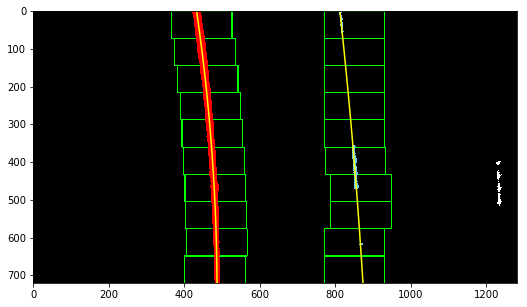

In [59]:
# visualize the result on example image
# Source: Lesson 33 - Finding the lanes

sampleimg = mpimg.imread('./test_images/test2.jpg')
sampleimg_bin = preprocess_image(sampleimg)

left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window(sampleimg_bin)

h = sampleimg.shape[0]
left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
#print('fit x-intercepts:', left_fit_x_int, right_fit_x_int)

rectangles = visualization_data[0]
histogram = visualization_data[1]

# Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((sampleimg_bin, sampleimg_bin, sampleimg_bin))*255)
# Generate x and y values for plotting
ploty = np.linspace(0,sampleimg_bin.shape[0]-1, sampleimg_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
for rect in rectangles:
# Draw the windows on the visualization image
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
# Identify the x and y positions of all nonzero pixels in the image
nonzero = sampleimg_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
plt.figure(figsize=(10,5))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig( 'output_images/sliding_window.jpg' ) 
plt.show()


In [22]:
# Source: Lesson 33, Finding the lanes

# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!

def previous_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

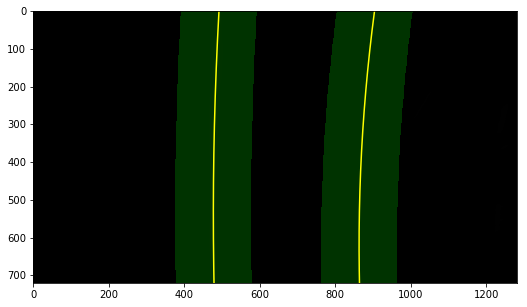

In [60]:
# Visualize the results with an sample image
# Source: Lesson 33: Finding the Lines

sampleimg = mpimg.imread('./test_images/test4.jpg')
binary_warped = preprocess_image(sampleimg)   
margin = 100

# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.figure(figsize=(10,5))
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig( 'output_images/previous_ft.jpg' ) 
plt.show()


In [24]:
# Source: Lesson 35 - Measuring Curvature

# Calculating radius and offset
def get_radius_and_offset(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720  # meters per pixel in y dimension , 720 px = height of the testimages
    xm_per_pix = 3.7/380 # meters per pixel in x dimension  380 px = distance in warped testimage inside 1 lane

    left_curverad, right_curverad, center_dist = (0, 0, 0)
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Calculate the offset
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        offset = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, offset

In [25]:
# Source: Lesson 36, Tipps & Tricks for the project

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
        
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
                # sanity check. Take this point only if it is the first
            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.) and len(self.current_fit) > 0:                
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 3:
                    # throw out old fits, keep newest 3
                    self.current_fit = self.current_fit[len(self.current_fit)-3:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # remove one from history, if none is found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # delete the oldest
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)

            

In [26]:
def process_image(img):
    new_img = np.copy(img)
    img_bin = preprocess_image(new_img)
    
    # if both, left AND right lines were detected in the last frame
    # use previous_fit else use sliding_window
    
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = previous_fit(img_bin, l_line.best_fit, r_line.best_fit)
        
    # sanity check, discard if x-intercept is not around 350 +/- 100 
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(new_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = get_radius_and_offset(img_bin, l_line.best_fit, r_line.best_fit, l_lane_inds, r_lane_inds)        
        img_out = write_text(img_out1, rad_l,rad_r, d_center)
    else:
        img_out = new_img
    
    return img_out


In [ ]:
#####################################################
####    I M A G E - P O S T P R O C E S S I N G   ###
#####################################################

In [28]:
# Source: Lesson 36, Tipps & Tricks for the project

def draw_lane(img, warped, left_fit, right_fit, Minv):
    new_img = np.copy(img)
    if left_fit is None or right_fit is None:
        return img
   
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = warped.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result


In [ ]:
sample = mpimg.imread('./test_images/test2.jpg')
sample_bin = preprocess_image(sample)
sample_out = draw_lane(sample, sample_bin, left_fit, right_fit, Minv)
plt.imshow(sample_out)
plt.show()

In [30]:
## Write Text on image
def write_text(img, left_radius, right_radius, offset):
    font = cv2.FONT_HERSHEY_TRIPLEX
    radius = (left_radius + right_radius)/2
        
    text = 'Avg. Radius: ' + '{:04.1f}'.format(radius) + 'm'
    cv2.putText(img,text, (40,70), font, 1.5, (255,255,255), 2, cv2.LINE_AA)

    offset_side = 'right'
    if offset <= 0:
        offset_side = 'left'
    offset = abs(offset)    
    text = 'Offset Center: {:02.2f}'.format(offset*100) + ' cm ' + offset_side
    cv2.putText(img,text, (40,120), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
    
    return img    

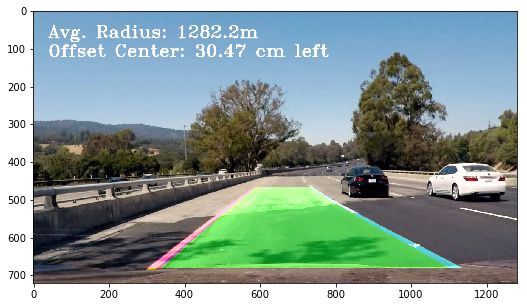

In [62]:
l_line = Line()
r_line = Line()
sampleimg = mpimg.imread('./test_images/test4.jpg')
procimg = process_image(sampleimg)
plt.figure(figsize=(10,5))
plt.imshow(procimg)
plt.savefig( 'output_images/lane_drawback.jpg' ) 
plt.show()

In [ ]:
#################################################
####    V I D E O - G E N E R A T I O N     #####
#################################################

In [35]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
#left = LaneFinder('left')
#right = LaneFinder('right')

cliplist = ["project_video"] # ,"challenge_video"]# ["harder_challenge_video"] 
for clip in cliplist:
    l_line = Line()
    r_line = Line()
    videoclip = VideoFileClip( clip + ".mp4") # .subclip(30,31)
    project_output = clip + '_output.mp4'
    project_clip = videoclip.fl_image(process_image) #NOTE: this function expects color images!!
    %time project_clip.write_videofile(project_output, audio=False)
    videoclip.reader.close()
    videoclip.audio.reader.close_proc()


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [03:43<00:00,  6.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 3min 45s


In [75]:


HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))
